In [519]:
model_setting = "cutler_cascade_003"
save_log_file = "output/" + model_setting + ".log"
coco_instance_result_file = "../predictions/" + model_setting + ".json"
annotation_file = '../data/coco_kvasirseg/val/annotations/val.json'
image_path = '../data/coco_kvasirseg/val/images/'
output_dir = 'evaluation/' + model_setting + '/'
num_images = 10
tasks = ['segmentation']
# acceptance_threshold = 0.9


In [520]:
import sys

class Tee:
    def __init__(self, *files):
        self.files = files

    def write(self, data):
        for f in self.files:
            f.write(data)
            f.flush()

    def flush(self):
        for f in self.files:
            f.flush()

log_file = open(save_log_file, "w")
sys.stdout = Tee(sys.__stdout__, log_file)
sys.stderr = Tee(sys.__stderr__, log_file)


In [521]:
import argparse
from typing import List, Dict, Tuple, Optional
import json
import os
import sys
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
from helper_func import decode_rle_mask, load_image, draw_annotations_on_image


In [522]:
def load_data(coco_instance_result_file: str, annotation_file: str) -> Tuple[Dict, Dict, Dict]:
    """
    Load predictions, images, and annotations from COCO format files.

    Args:
        coco_instance_result_file: Path to COCO format predictions JSON file
        annotation_file: Path to COCO format ground truth annotations JSON file

    Returns:
        Tuple of (image_info_dict, annotation_dict, prediction_dict)
        - image_info_dict: dict mapping image_id to image info
        - annotation_dict: dict mapping image_id to list of annotations
        - prediction_dict: dict mapping image_id to list of predictions
    """
    if not os.path.exists(coco_instance_result_file):
        raise FileNotFoundError(f"Predictions file not found: {coco_instance_result_file}")
    if not os.path.exists(annotation_file):
        raise FileNotFoundError(f"Annotation file not found: {annotation_file}")

    # Load predictions
    prediction_dict = {}
    with open(coco_instance_result_file, 'r') as f:
        predictions = json.load(f)
    
    for prediction in predictions:
        image_id = prediction['image_id']
        if image_id not in prediction_dict:
            prediction_dict[image_id] = []
        prediction_dict[image_id].append(prediction)

    # Load ground truth annotations
    image_info_dict = {}
    annotation_dict = {}
    
    with open(annotation_file, 'r') as f:
        ground_truth = json.load(f)
        images = ground_truth.get('images', [])
        annotations = ground_truth.get('annotations', [])
        
        # Build image info dictionary
        for image in images:
            image_info_dict[image['id']] = image
        
        # Build annotation dictionary
        for annotation in annotations:
            img_id = annotation['image_id']
            if img_id not in annotation_dict:
                annotation_dict[img_id] = []
            annotation_dict[img_id].append(annotation)
    
    return image_info_dict, annotation_dict, prediction_dict


In [523]:
image_info_dict, annotation_dict, prediction_dict = load_data(coco_instance_result_file, annotation_file)

In [524]:
def extract_tp_fp_fn_from_cocoeval(coco_eval: COCOeval, iou_thresh: float = 0.5) -> Dict[str, int]:
    """
    Extract TP, FP, FN counts from COCOeval object.
    
    This function extracts true positives, false positives, and false negatives
    from the COCOeval evaluation results at a specific IoU threshold.
    
    Args:
        coco_eval: COCOeval object after evaluate() has been called
        iou_thresh: IoU threshold to use for matching (default: 0.5)
    
    Returns:
        Dictionary with 'tp', 'fp', 'fn' counts
    """
    # # Find the index of the IoU threshold closest to iou_thresh
    # iou_thresh_idx = np.argmin(np.abs(coco_eval.params.iouThrs - iou_thresh))
    
    # # Get matches at this IoU threshold
    # # dtMatches shape: [T, R, K, A, M] where:
    # #   T = IoU thresholds, R = recall thresholds, K = classes, A = areas, M = max dets
    # dtMatches = coco_eval.eval['dtMatches'][iou_thresh_idx]  # [R, K, A, M]
    # gtMatches = coco_eval.eval['gtMatches'][iou_thresh_idx]  # [R, K, A, M]
    
    # # Use the last recall threshold (most permissive) and last max_det setting
    # recall_idx = -1
    # max_det_idx = -1  # Use maximum detections setting
    
    # tp = 0
    # fp = 0
    # fn = 0
    
    # # Iterate over all classes and areas
    # for class_idx in range(dtMatches.shape[1]):  # K classes
    #     for area_idx in range(dtMatches.shape[2]):  # A areas
    #         # Get matches for this class/area combination
    #         dt_matches = dtMatches[recall_idx, class_idx, area_idx, max_det_idx]
    #         gt_matches = gtMatches[recall_idx, class_idx, area_idx, max_det_idx]
            
    #         # TP: number of detections that matched (non-zero values in dtMatches)
    #         tp += np.sum(dt_matches > 0)
            
    #         # FP: number of detections that didn't match
    #         fp += np.sum(dt_matches == 0)
            
    #         # FN: number of ground truths that didn't match
    #         fn += np.sum(gt_matches == 0)
    
    # return {
    #     'tp': int(tp),
    #     'fp': int(fp),
    #     'fn': int(fn)
    # }
    pass

def compute_ap_scores(coco_instance_result_file: str, annotation_file: str, 
                      iou_type: str = 'bbox') -> Tuple[Dict[str, float], COCOeval]:
    """
    Compute AP (Average Precision) scores using COCO evaluation API.
    
    Args:
        coco_instance_result_file: Path to predictions JSON file
        annotation_file: Path to ground truth annotations JSON file
        iou_type: Type of IoU to use ('bbox' or 'segm')
    
    Returns:
        Tuple of (ap_scores dict, coco_eval object for PR curve)
    """
    if not os.path.exists(annotation_file):
        raise FileNotFoundError(f"Annotation file not found: {annotation_file}")
    if not os.path.exists(coco_instance_result_file):
        raise FileNotFoundError(f"Predictions file not found: {coco_instance_result_file}")
    
    # Load ground truth
    coco_gt = COCO(annotation_file)
    
    # Load predictions
    with open(coco_instance_result_file, 'r') as f:
        predictions = json.load(f)
    
    coco_dt = coco_gt.loadRes(predictions)
    
    # Run COCO evaluation
    coco_eval = COCOeval(coco_gt, coco_dt, iou_type)
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    # Extract AP scores
    ap_scores = {
        'AP': coco_eval.stats[0],      # AP @ IoU=0.50:0.95
        'AP50': coco_eval.stats[1],    # AP @ IoU=0.50
        'AP75': coco_eval.stats[2],    # AP @ IoU=0.75
        'AP_small': coco_eval.stats[3], # AP for small objects
        'AP_medium': coco_eval.stats[4], # AP for medium objects
        'AP_large': coco_eval.stats[5],  # AP for large objects
        'AR_1': coco_eval.stats[6],     # AR given 1 det per image
        'AR_10': coco_eval.stats[7],   # AR given 10 dets per image
        'AR_100': coco_eval.stats[8],  # AR given 100 dets per image
    }
    
    # # Extract TP, FP, FN at IoU=0.5
    # tp_fp_fn = extract_tp_fp_fn_from_cocoeval(coco_eval, iou_thresh=0.5)
    # ap_scores.update(tp_fp_fn)
    
    return ap_scores, coco_eval


In [525]:
ap_scores, coco_eval = compute_ap_scores(coco_instance_result_file, annotation_file)
print(ap_scores)

In [526]:
def _compute_bbox_iou(bbox1: List[float], bbox2: List[float]) -> float:
    """Compute IoU between two bounding boxes in COCO format [x, y, w, h]."""
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    
    # Convert to (x1, y1, x2, y2) format
    box1 = [x1, y1, x1 + w1, y1 + h1]
    box2 = [x2, y2, x2 + w2, y2 + h2]
    
    # Calculate intersection
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    # Calculate union
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0.0


In [527]:
def plot_pr_curve(coco_eval: COCOeval, output_dir: str) -> None:
    assert coco_eval.eval is not None, "Call evaluate() and accumulate() first"

    import os
    import numpy as np
    import matplotlib.pyplot as plt

    iouType = coco_eval.params.iouType or "coco"
    os.makedirs(output_dir, exist_ok=True)

    precision = coco_eval.eval['precision']  # [T, R, K, A, M]
    recall = coco_eval.params.recThrs

    precision = np.where(precision > -1, precision, np.nan)

    # COCO-standard: area=all (0), maxDets=100 (-1)
    precision_mean = np.nanmean(
        precision[:, :, :, 0, -1], axis=2
    )

    plt.figure(figsize=(10, 6))
    for i, iou in enumerate(coco_eval.params.iouThrs):
        plt.plot(recall, precision_mean[i], label=f'IoU={iou:.2f}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({iouType.upper()})')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    path = os.path.join(output_dir, f'pr_curve_{iouType}.png')
    plt.savefig(path, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"PR curve saved to: {path}")


In [528]:
plot_pr_curve(coco_eval, output_dir)

In [529]:
# def _plot_segmentation_analysis(image_path: str, image_info: Dict, 
#                                 anno_mask: np.ndarray, pred_mask: np.ndarray,
#                                 tp: int, fp: int, fn: int, plot_dir: str) -> None:
#     """Create visualization for segmentation analysis."""
#     os.makedirs(plot_dir, exist_ok=True)
    
#     # Load image
#     full_image_path = os.path.join(image_path, image_info['file_name'])
#     if not os.path.exists(full_image_path):
#         print(f"Image not found: {full_image_path}")
#         return
    
#     img = load_image(full_image_path)
    
#     # Create comparison mask: white=TP, yellow=FP, red=FN
#     h, w = anno_mask.shape
#     comparison = np.zeros((h, w, 3), dtype=np.uint8)
#     comparison[anno_mask & pred_mask] = [255, 255, 255]  # TP: white
#     comparison[pred_mask & ~anno_mask] = [255, 255, 0]   # FP: yellow
#     comparison[anno_mask & ~pred_mask] = [255, 0, 0]     # FN: red
    
#     # Create figure
#     fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
#     # Original image
#     axes[0].imshow(img)
#     axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
#     axes[0].axis('off')
    
#     # Ground truth mask
#     axes[1].imshow(anno_mask, cmap='gray')
#     axes[1].set_title('Ground Truth', fontsize=12, fontweight='bold')
#     axes[1].axis('off')
    
#     # Prediction mask
#     axes[2].imshow(pred_mask, cmap='gray')
#     axes[2].set_title('Predictions', fontsize=12, fontweight='bold')
#     axes[2].axis('off')
    
#     # Comparison overlay
#     axes[3].imshow(img)
#     axes[3].imshow(comparison, alpha=0.5)
#     axes[3].set_title(f'Comparison (TP:{tp}, FP:{fp}, FN:{fn})', fontsize=12, fontweight='bold')
#     axes[3].axis('off')
    
#     plt.tight_layout()
#     output_path = os.path.join(plot_dir, f"seg_{image_info['id']}.png")
#     plt.savefig(output_path, dpi=150, bbox_inches='tight')
#     plt.close()


# def _plot_bbox_analysis(image_path: str, image_info: Dict,
#                         annos: List[Dict], preds: List[Dict],
#                         matched_preds: set, matched_annos: set,
#                         plot_dir: str) -> None:
#     """Create visualization for bbox analysis."""
#     os.makedirs(plot_dir, exist_ok=True)
    
#     # Load image
#     full_image_path = os.path.join(image_path, image_info['file_name'])
#     if not os.path.exists(full_image_path):
#         print(f"Warning: Image not found: {full_image_path}")
#         return
    
#     img = load_image(full_image_path)
    
#     # Create visualization
#     fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
#     # Ground truth
#     gt_img = draw_annotations_on_image(img.copy(), annos, color=(0, 255, 0))
#     axes[0].imshow(gt_img)
#     axes[0].set_title(f'Ground Truth ({len(annos)} boxes)', fontsize=12, fontweight='bold')
#     axes[0].axis('off')
    
#     # Predictions
#     pred_img = draw_annotations_on_image(img.copy(), preds, color=(255, 0, 0), show_scores=True)
#     axes[1].imshow(pred_img)
#     axes[1].set_title(f'Predictions ({len(preds)} boxes)', fontsize=12, fontweight='bold')
#     axes[1].axis('off')
    
#     # Combined (green=GT, red=pred, blue=matched)
#     combined_img = img.copy()
#     for i, pred in enumerate(preds):
#         if i in matched_preds:
#             color = (0, 0, 255)  # Blue for matched
#         else:
#             color = (255, 0, 0)  # Red for unmatched
#         if 'bbox' in pred:
#             combined_img = draw_annotations_on_image(combined_img, [pred], color=color)
    
#     for j, anno in enumerate(annos):
#         if j not in matched_annos:
#             if 'bbox' in anno:
#                 combined_img = draw_annotations_on_image(combined_img, [anno], color=(0, 255, 0))
    
#     axes[2].imshow(combined_img)
#     axes[2].set_title(f'Combined (TP:{len(matched_preds)})', fontsize=12, fontweight='bold')
#     axes[2].axis('off')
    
#     plt.tight_layout()
#     output_path = os.path.join(plot_dir, f"bbox_{image_info['id']}.png")
#     plt.savefig(output_path, dpi=150, bbox_inches='tight')
#     plt.close()


Print the macro average for metrics

In [530]:
score_threshold_acceptance = 0.6 ## minimum score threshold for predictions
iou_threshold_acceptance = 0.5 ## minimum iou threshold for matching predictions to ground truth

In [531]:
## assign the predictions to the ground truth
## then compute the metrics on each pair
from typing import List, Dict, Tuple, Any
def _compute_iou(predBox: List[float], annoBox: List[float]) -> float:
    x1, y1, w1, h1 = predBox
    x2, y2, w2, h2 = annoBox

    inter_area = max(0, min(x1 + w1, x2 + w2) - max(x1, x2)) * max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    union_area = w1 * h1 + w2 * h2 - inter_area
    return inter_area / union_area

def compute_metrics(pred_mask: np.ndarray, anno_mask: np.ndarray) -> Dict[str, float]:
    ## compute tp, fp, fn, tn for each pixel
    if pred_mask is None or anno_mask is None:
        return {'precision': 0.0, 'recall': 0.0, 'dice': 0.0, 'jaccard': 0.0}
    tp = np.sum(pred_mask & anno_mask)
    fp = np.sum(pred_mask & ~anno_mask)
    fn = np.sum(anno_mask & ~pred_mask)
    tn = np.sum(~pred_mask & ~anno_mask)
    
    ## compute precision, recall, dice, jaccard
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
    jaccard = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

    return {'precision': precision, 'recall': recall, 'dice': dice, 'jaccard': jaccard}

def assign_predictions_to_ground_truth(preds: List[Dict[str, Any]], annos: List[Dict[str, Any]], threshold: float = 0.5) -> List[Tuple[Dict[str, Any], Dict[str, Any]]]:
    if len(preds) == 0 or len(annos) == 0:
        # print("No predictions or ground truth found")
        return []
    pred_bboxs = [pred['bbox'] for pred in preds]
    anno_bboxs = [anno['bbox'] for anno in annos]

    iou_matrix = np.zeros((len(pred_bboxs), len(anno_bboxs)))

    for i, pred_bbox in enumerate(pred_bboxs):
        for j, anno_bbox in enumerate(anno_bboxs):
            iou_matrix[i, j] = _compute_iou(pred_bbox, anno_bbox)

    matching_gt_to_pred = [None] * len(annos)
    for i, anno in enumerate(annos):
        best_match = np.argmax(iou_matrix[:, i])
        if iou_matrix[best_match, i] >= threshold:
            matching_gt_to_pred[i] = best_match
            iou_matrix[best_match, :] = np.array([0.0] * iou_matrix.shape[1])
        else:
            matching_gt_to_pred[i] = -1
    
    prediction_pairs = []
    for i in range(len(annos)):
        if matching_gt_to_pred[i] == -1:
            prediction_pairs.append((None, annos[i]))
        else:
            prediction_pairs.append((preds[matching_gt_to_pred[i]], annos[i]))
    return prediction_pairs




In [532]:
## macro average: matching predictions to ground truth and compute average on metrics
def macro_average(preds, annos, score_threshold_acceptance, iou_threshold_acceptance):
    metrics_across_all = {}
    for index in annotation_dict.keys():
        annos = annotation_dict[index].copy()
        preds = prediction_dict[index].copy()
        preds = [pred for pred in preds if pred['score'] >= score_threshold_acceptance]
        prediction_pairs = assign_predictions_to_ground_truth(preds, annos, threshold=iou_threshold_acceptance)
        
        metrics = []
        for item in prediction_pairs:
            pred, anno = item

            pred_mask, anno_mask = None, None
            if pred is not None:
                pred_mask = np.array(decode_rle_mask(pred['segmentation']))
            if anno is not None:
                anno_mask = np.array(decode_rle_mask(anno['segmentation']))
            metrics.append(compute_metrics(pred_mask, anno_mask))

        if metrics:
            mean_metrics = {k: np.mean([m[k] for m in metrics]) for k in metrics[0].keys()}
        else:
            mean_metrics = {'precision': 0.0, 'recall': 0.0, 'dice': 0.0, 'jaccard': 0.0}
        metrics_across_all[index] = mean_metrics
        # else:
        #     metrics_across_all[index] = {'precision': 0.0, 'recall': 0.0, 'dice': 0.0, 'jaccard': 0.0}

    final_metrics = {k: np.mean([m[k] for m in metrics_across_all.values()]) for k in metrics_across_all[0].keys()}
    # print("Macro Average Metrics:")
    # print('\n'.join([f"{k}: {v:.4f}" for k, v in final_metrics.items() if k in metrics_across_all[0].keys()]))
    return final_metrics


In [533]:
macro_metrics = macro_average(prediction_dict, annotation_dict, score_threshold_acceptance, iou_threshold_acceptance)
print("Macro Average Metrics:")
print('\n'.join([f"{k}: {v:.4f}" for k, v in macro_metrics.items()]))

In [534]:
def union_mask(mask_list) -> np.ndarray | None:
        if not mask_list:
            return None
        zero = np.zeros_like(mask_list[0])
        for mask in mask_list:
            zero |= mask
        return zero

In [535]:
def micro_average(preds, annos, score_threshold_acceptance):

    ## micro average: doing or operation on mask
    micro_metrics = []
    for index in annotation_dict.keys():
        annos = annotation_dict[index].copy()
        preds = prediction_dict[index].copy()
        preds = [pred for pred in preds if pred['score'] >= score_threshold_acceptance]

        anno_mask_list = [decode_rle_mask(anno['segmentation']) for anno in annos]
        pred_mask_list = [decode_rle_mask(pred['segmentation']) for pred in preds]
        anno_mask = union_mask(anno_mask_list)
        pred_mask = union_mask(pred_mask_list)

        metrics = compute_metrics(anno_mask, pred_mask) ## precision, recall, f1, dice, jaccard on pixels
        micro_metrics.append(metrics)

    final_micro_metrics = {k: np.mean([m[k] for m in micro_metrics]) for k in micro_metrics[0].keys()}

    # print("Micro Average Metrics:")
    # print('\n'.join([f"{k}: {v:.4f}" for k, v in final_micro_metrics.items() if k in micro_metrics[0].keys()]))
    return final_micro_metrics

        

In [536]:
micro_metrics = micro_average(prediction_dict, annotation_dict, score_threshold_acceptance)
print("Micro Average Metrics:")
print('\n'.join([f"{k}: {v:.4f}" for k, v in micro_metrics.items()]))


In [537]:
num_plot_images = 10

In [538]:
def plot_mask(anno_mask, pred_mask, image_path, plot_dir, index=None):
    os.makedirs(plot_dir, exist_ok=True)
    h, w = anno_mask.shape
    comparison = np.zeros((h, w, 3), dtype=np.uint8)
    comparison[np.logical_and(anno_mask, pred_mask, dtype=bool)] = [255, 255, 255]  # TP: white
    comparison[np.logical_and(pred_mask, 1 - anno_mask, dtype=bool)] = [255, 255, 0]   # FP: yellow
    comparison[np.logical_and(anno_mask, 1 - pred_mask, dtype=bool)] = [255, 0, 0]     # FN: red 
    
    image = load_image(image_path)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ## show image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # axes[1].imshow(anno_mask, cmap='gray')
    # axes[1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    # axes[1].axis('off')

    # axes[2].imshow(pred_mask, cmap='gray')
    # axes[2].set_title('Predictions', fontsize=12, fontweight='bold')
    # axes[2].axis('off')

    axes[1].imshow(comparison)
    axes[1].set_title('Comparison', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    path_to_save = os.path.join(plot_dir, f"mask_{index}.png")
    plt.tight_layout()
    plt.savefig(path_to_save, dpi=150, bbox_inches='tight')
    print(f"Saved to {path_to_save}")

    plt.close()
    
    
    


In [539]:
## find all index that have more than 1 annotations

multiple_anno_ids = []
for index in annotation_dict.keys():
    annos = annotation_dict[index].copy()
    if len(annos) >= 2:
        multiple_anno_ids.append(index)

for index in multiple_anno_ids:
    annos = annotation_dict[index].copy()
    preds = prediction_dict[index].copy()
    preds = [pred for pred in preds if pred['score'] >= 0.5]

    anno_mask_list = [decode_rle_mask(anno['segmentation']) for anno in annos]
    pred_mask_list = [decode_rle_mask(pred['segmentation']) for pred in preds]
    anno_mask = union_mask(anno_mask_list)
    pred_mask = union_mask(pred_mask_list)

    image_file_path = os.path.join(image_path, image_info_dict[index]['file_name'])
    plot_mask(anno_mask, pred_mask, image_file_path, plot_dir=output_dir + 'mask/', index=index)
    
    
    

In [540]:
for index in annotation_dict.keys():
    if index >= num_plot_images:
        continue
    annos = annotation_dict[index].copy()
    preds = prediction_dict[index].copy()
    preds = [pred for pred in preds if pred['score'] >= 0.5]

    anno_mask_list = [decode_rle_mask(anno['segmentation']) for anno in annos]
    pred_mask_list = [decode_rle_mask(pred['segmentation']) for pred in preds]
    anno_mask = union_mask(anno_mask_list)
    pred_mask = union_mask(pred_mask_list)

    image_file_path = os.path.join(image_path, image_info_dict[index]['file_name'])
    plot_mask(anno_mask, pred_mask, image_file_path, plot_dir=output_dir + 'mask/', index=index)
    
    
    

In [541]:
import matplotlib.patches as patches
import numpy as np
from typing import List, Tuple, Dict, Any

def plot_mask_and_bbox(prediction_pairs: List[Tuple[Dict[str, Any], Dict[str, Any]]], image_path, plot_dir, index=None):
    """
    Visualize predictions and ground truth masks/bboxes.
    
    - Predictions: yellow
    - Ground truth: red
    - Masks: semi-transparent overlays
    """
    # Load image
    image = load_image(image_path)  # user-defined
    fig, ax = plt.subplots(figsize=(12, 12))  # square layout for easier viewing
    
    ax.imshow(image)
    
    for pred, anno in prediction_pairs:
        # --- Plot prediction ---
        if pred is not None:
            # bbox
            if 'bbox' in pred:
                x, y, w, h = pred['bbox']
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='gold', facecolor='none')
                ax.add_patch(rect)
            # mask
            if 'segmentation' in pred:
                mask = decode_rle_mask(pred['segmentation'])
                ax.imshow(mask, cmap='YlOrBr', alpha=0.4)  # yellow-orange colormap
        
        # --- Plot annotation ---
        if anno is not None:
            # bbox
            if 'bbox' in anno:
                x, y, w, h = anno['bbox']
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
            # mask
            if 'segmentation' in anno:
                mask = decode_rle_mask(anno['segmentation'])
                ax.imshow(mask, cmap='Reds', alpha=0.3)
    
    ax.axis('off')
    plt.tight_layout()
    
    # Ensure plot_dir exists
    os.makedirs(plot_dir, exist_ok=True)
    
    # Save figure
    save_name = f"mask_and_bbox_{index}.png" if index is not None else "mask_and_bbox.png"
    save_path = os.path.join(plot_dir, save_name)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved to {save_path}")
    plt.close()

In [542]:

multiple_anno_ids = []
for index in annotation_dict.keys():
    annos = annotation_dict[index].copy()
    if len(annos) >= 2:
        multiple_anno_ids.append(index)

for index in multiple_anno_ids:
    annos = annotation_dict[index].copy()
    preds = prediction_dict[index].copy()
    prediction_pairs = assign_predictions_to_ground_truth(preds, annos, threshold=iou_threshold_acceptance)
    image_file_path = os.path.join(image_path, image_info_dict[index]['file_name'])
    plot_mask_and_bbox(prediction_pairs, image_file_path, plot_dir=output_dir + 'mask_and_bbox', index=index)


In [543]:
## macro average: matching predictions to ground truth and compute average on metrics
metrics_across_all = {}
for index in annotation_dict.keys():
    if index >= num_plot_images:
        continue
    annos = annotation_dict[index].copy()
    preds = prediction_dict[index].copy()
    prediction_pairs = assign_predictions_to_ground_truth(preds, annos, threshold=iou_threshold_acceptance)
    image_file_path = os.path.join(image_path, image_info_dict[index]['file_name'])
    plot_mask_and_bbox(prediction_pairs, image_file_path, plot_dir=output_dir + 'mask_and_bbox', index=index)


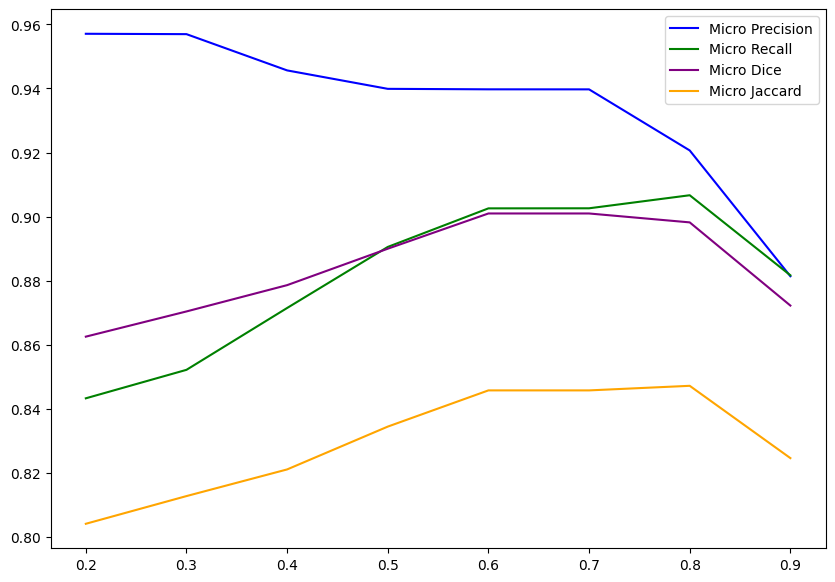

In [544]:
## for score_threshold_acceptance from 0.5 to 0.95 step 0.05, plot precision, recall, dice, jaccard for micro and macro
score_thresh_sweep = np.arange(0.2, 1.0, 0.1).round(2).tolist()

precisions_micro, recalls_micro, dices_micro, jaccards_micro = [], [], [], []
precisions_macro, recalls_macro, dices_macro, jaccards_macro = [], [], [], []
for score_thresh in score_thresh_sweep:
    micro_metrics = micro_average(prediction_dict, annotation_dict, score_thresh)
    precisions_micro.append(micro_metrics['precision'])
    recalls_micro.append(micro_metrics['recall'])
    dices_micro.append(micro_metrics['dice'])
    jaccards_micro.append(micro_metrics['jaccard'])


## plot precision, recall, f1, dice, jaccard for micro and macro
fig = plt.figure(figsize=(10, 7))
plt.plot(score_thresh_sweep, precisions_micro, label='Micro Precision', color='blue')
plt.plot(score_thresh_sweep, recalls_micro, label='Micro Recall', color='green')
plt.plot(score_thresh_sweep, dices_micro, label='Micro Dice', color='purple')
plt.plot(score_thresh_sweep, jaccards_micro, label='Micro Jaccard', color='orange')
plt.legend()
fig.savefig(os.path.join(output_dir, 'metrics_on_varies_score_acceptance_rate.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [545]:
score_sweep = [0.5, 0.6, 0.7, 0.8, 0.9]
for score in score_sweep:
    print("For score = ", score)
    micro_metrics = micro_average(prediction_dict, annotation_dict, score_threshold_acceptance=score)
    print("Micro Average Metrics:")
    print(', '.join([f"{k}: {v:.4f}" for k, v in micro_metrics.items()]))

In [546]:
sys.stdout = sys.__stdout__
sys.stderr = sys.__stderr__
log_file.close()